# Installing and loading packages

Beginner's guide: http://ucidatascienceinitiative.github.io/IntroToJulia/

In [1]:
using Pkg
# Pkg.add("Plots")
# Pkg.add("MultivariateStats")
# Pkg.add("GLM")
# Pkg.add("DifferentialEquations")

In [2]:
using DifferentialEquations, Plots, DiffEqBayes, Turing

using Turing, Distributions, DifferentialEquations 

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1278


In [21]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278
┌ Warning: Module Plots with build ID 923631360810112 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Info: Skipping precompilation since __precompile__(false). Importing StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd].
└ @ Base loading.jl:1034
┌ Info: Precompiling DataValues [e7dc6d0d-1eca-5fa6-8ad6-5aecde8b7ea5]
└ @ Base loading.jl:1278
┌ Info: Precompiling Widgets [cc8bc4a8-27d6-5769-a93b-9d913e69aa62]
└ @ Base loading.jl:1278
┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1278
┌ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1278


# Functions and multiple dispatch

The function below has 5 methods. Its output depends on the type of the input (without any conditional statement). This is multiple dispatch and improves performance.

In [ ]:
f(x,y) = 2x+y # Create an inline function
function f(x)
  x+2  
end # Long form definition
f(x::Int,y::Int) = 3x+2y

f(x::T,y::T) where {T<:Number}= 4x+10y
f(x::T,y::T2,z::T2) where {T<:Number,T2} = 5x + 5y + 5z


In [ ]:
f(2,3) # 3x+2y

In [ ]:
f(2.0,3) # 2x+y since 2.0 is not an Int

In [ ]:
f(2.0,3.0) # 4x+10y

In [ ]:
f(2, 3.0, 4.0) #5x + 5y + 5z

# Ordinary Differential Equations

## Scalar equation

Solving an ODE numerically

Step 1: Defining the problem

In [ ]:
f(u,p,t) = 1.01*u
u0=1/2
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)

Step 2: Solve the problem

In [ ]:
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

Step 3: Analyze the solution

Accessing elements of the solution

In [ ]:
sol[5] # The value at the fifth time step
sol.t[8]
[t+2u for (u,t) in zip(sol.u,sol.t)]
sol(0.45) # The value of the solution at t=0.45

In [ ]:
plot(sol,linewidth=5,title="Solution to the linear ODE",
     xaxis="Time (t)",yaxis="u(t) (in μm)",label="Numerical solution")

plot!(sol.t,t->0.5*exp(1.01t),lw=3,ls=:dash,label="Analytical solution")

## Sytems of equations

Define the problem

In [ ]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

In [ ]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob)

In [ ]:
# plot(sol)
plot(sol,vars=(0,2)) #Here "variable 0" corresponds to the independent variable ("time")

Phase space plot

In [ ]:
plot(sol,vars=(1,2,3))

## Non-homogenous system

In [22]:
l = 1.0                             # length [m]
m = 1.0                             # mass[m]
g = 9.81                            # gravitational acceleration [m/s²]

function pendulum!(du,u,p,t)
    du[1] = u[2]                    # θ'(t) = ω(t)
    du[2] = -3g/(2l)*sin(u[1]) + 3/(m*l^2)*p(t) # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
end

θ₀ = 0.01                           # initial angular deflection [rad]
ω₀ = 0.0                            # initial angular velocity [rad/s]
u₀ = [θ₀, ω₀]                       # initial state vector
tspan = (0.0,10.0)                  # time interval

M = t->0.1sin(t)                    # external torque [Nm]

prob = ODEProblem(pendulum!,u₀,tspan,M)
sol = solve(prob)

LoadError: UndefVarError: plot not defined

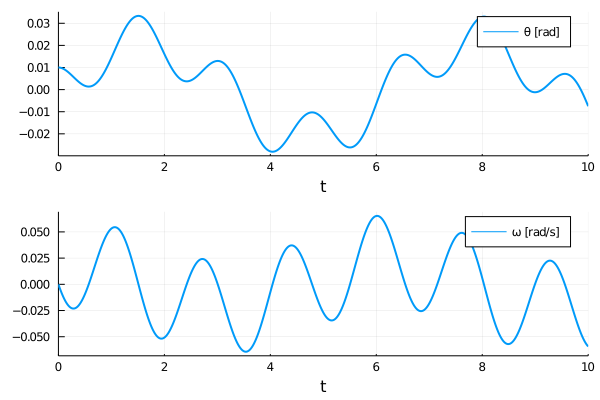

In [23]:
Plots.plot(sol,linewidth=2,xaxis="t",label=["θ [rad]" "ω [rad/s]"],layout=(2,1))

In [24]:
M

#1 (generic function with 1 method)

## Parameterized systems

TIP: \alpha + tab results in Greek letters

In [ ]:
function parameterized_lorenz(du,u,p,t)
  x,y,z = u
  σ,ρ,β = p
  du[1] = dx = σ*(y-x)
  du[2] = dy = x*(ρ-z) - y
  du[3] = dz = x*y - β*z
end
u0 = [1.0,0.0,0.0]
tspan = (0.0,1.0)
p = [10.0,28.0,8/3]
prob = ODEProblem(parameterized_lorenz,u0,tspan,p)

In [ ]:
sol = solve(prob)

## Pseudo-code definition

In [ ]:
using ParameterizedFunctions
g = @ode_def begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ ρ β
u0 = [1.0;0.0;0.0]
tspan = (0.0,1.0)
p = [10.0,28.0,8/3]
prob = ODEProblem(g,u0,tspan,p)

# Stochastic Differential Equations

Define the deterministic (f) and the stochastic (g) parts of the problem separately

In [8]:
function lorenz(du,u,p,t)
  du[1] = 10.0(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - (8/3)*u[3]
end

function σ_lorenz(du,u,p,t)
  du[1] = 3.0
  du[2] = 3.0
  du[3] = 3.0
end

prob_sde_lorenz = SDEProblem(lorenz,σ_lorenz,[1.0,0.0,0.0],(0.0,10.0))
sol = solve(prob_sde_lorenz)


LoadError: UndefVarError: plot not defined

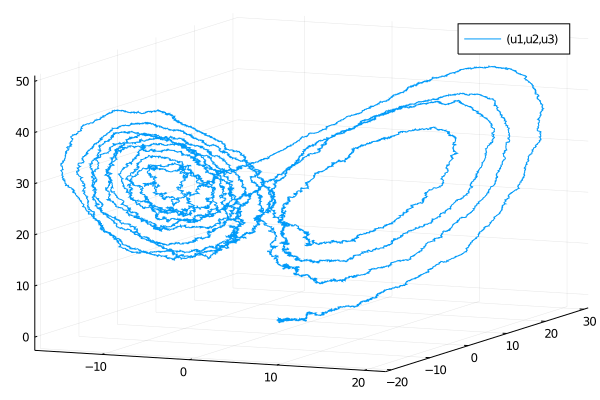

In [10]:
Plots.plot(sol,vars=(1,2,3))

Parameterized noise function

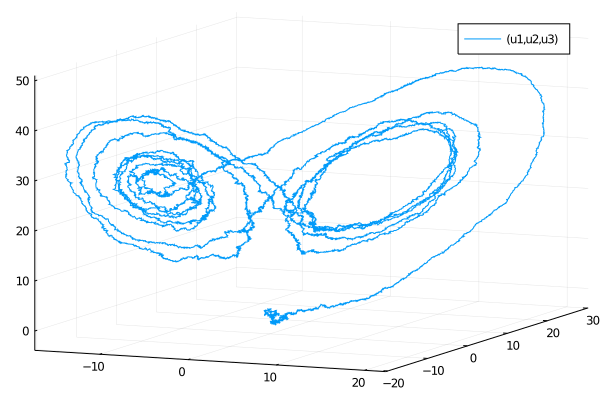

In [13]:
function σ_lorenz(du,u,p,t)
  du[1] = sin(u[3])*3.0
#   du[2] = u[2]*u[1]*3.0
  du[2] =3.0
  du[3] = 3.0
end

prob_sde_lorenz = SDEProblem(lorenz,σ_lorenz,[1.0,0.0,0.0],(0.0,10.0))
sol = solve(prob_sde_lorenz)
Plots.plot(sol,vars=(1,2,3))

# Parameter Estimation

Example from [here](https://turing.ml/stable/tutorials/10-bayesiandiffeq/#inference-of-a-stochastic-differential-equation)

  6.100310 seconds (24.43 M allocations: 683.339 MiB, 2.60% gc time)


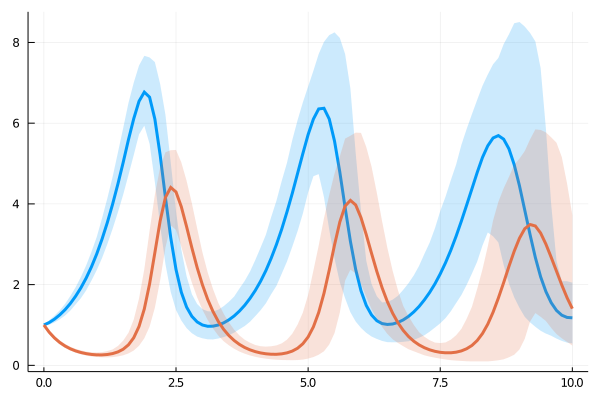

In [25]:
u0 = [1.0,1.0]
tspan = (0.0,10.0)
function multiplicative_noise!(du,u,p,t)
  x,y = u
  du[1] = p[5]*x
  du[2] = p[6]*y
end
p = [1.5,1.0,3.0,1.0,0.1,0.1]

function lotka_volterra!(du,u,p,t)
  x,y = u
  α,β,γ,δ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = δ*x*y - γ*y
end


prob_sde = SDEProblem(lotka_volterra!,multiplicative_noise!,u0,tspan,p)

ensembleprob = EnsembleProblem(prob_sde)
@time data = solve(ensembleprob,SOSRI(),saveat=0.1,trajectories=1000)
Plots.plot(EnsembleSummary(data))